# <span style="color:blue;">OpenPIV-Python-CPU Masking Tutorial</span>

Please use the following link to run this notebook from Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ali-sh-96/openpiv-python-cpu/blob/main/openpiv_cpu/tutorials/openpiv_python_cpu_masking_tutorial.ipynb)

This tutorial demonstrates how to create a mask to use as an input for `piv_cpu` function in OpenPIV-Python-CPU. To this end, a calibration image for a NACA 0025 airfoil (acquired in the Turbulence Research Lab, University of Toronto) is used. The image is 2052 by 4603 pixels squared and approximately 18.1 MB in size. The resulting mask is presented as an image and can be saved for subsequent PIV analysis.

## <span style="color:blue;">Dependencies</span>

The `openpiv-python-cpu` package only contains the packages strictly needed for PIV analysis, which typically includes only `pyfftw`, as `numpy`, `scipy`, and `numba` are already preinstalled in most Python distributions. The choice of the libraries needed to create or save a mask is left to the users. In this tutorial, OpenCV-Python and `matplotlib` are used to load the calibration image and create the mask, respectively.

In [1]:
#@title Import the needed libraries
#@markdown Run this block to import the dependencies.
import pkg_resources
import os
import cv2
import numpy as np
import matplotlib.path as mplpath
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#@title Install `openpiv-python-cpu`
#@markdown Run this block to install `openpiv-python-cpu`.
!pip install git+https://github.com/ali-sh-96/openpiv-python-cpu
from openpiv_cpu.cpu_process import piv_cpu

# Get the path to the installed package.
openpiv_path = pkg_resources.resource_filename('openpiv_cpu', '')
tutorial_path = os.path.join(openpiv_path, 'tutorials/')

  Cloning https://github.com/ali-sh-96/openpiv-python-cpu to /tmp/pip-req-build-_5u2ei93
  Running command git clone --filter=blob:none --quiet https://github.com/ali-sh-96/openpiv-python-cpu /tmp/pip-req-build-_5u2ei93
  Resolved https://github.com/ali-sh-96/openpiv-python-cpu to commit 8aad446139723aba2c8a97fa862588f08f13dea6
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 5.0 MB/s eta 0:00:00
  Created wheel for OpenPIV-Python-CPU: filename=OpenPIV_Python_CPU-1.1.0-py3-none-any.whl size=62373817 sha256=4284e44e5318d3da73f6a35fe3512fbf0a3cb82f3602a68f284e7c38c8a84eb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-lzn84j58/wheels/6f/31/b7/db282a2e2db8f3ce11a5831a18d2ae8a26b43fadcd7ba7f225
Successfully built OpenPIV-Python-CPU


## <span style="color:blue;">Calibration</span>

To initiate the mask creation process for the airfoil, the initial step involves extracting the pixel density from the calibration image. This pixel density serves as a crucial factor in establishing the relationship between the image dimensions and the real-world dimensions. In this specific instance, the airfoil model had a chord length of 30 cm and the pixel density was determined to be `M = 171`, as evidenced by the calibration image loaded below.

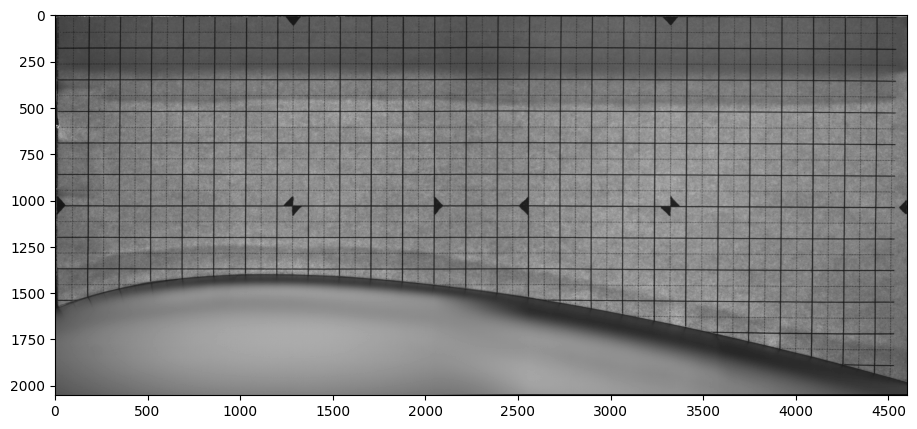

In [3]:
#@title Load the calibration image
# Load the airfoil mask.
test_dir = tutorial_path + "test4/"
cali = cv2.imread(test_dir + "Calibration.tif", cv2.IMREAD_GRAYSCALE)
frame = cv2.imread(test_dir + "Frame.tif", cv2.IMREAD_GRAYSCALE)
ht, wd = cali.shape
fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(cali, cmap='gray')

# Modify tick labels and ticks.
tick_step = 250
plt.xticks(range(0, wd, 2 * tick_step))
plt.yticks(range(0, ht, tick_step))
plt.show()

Next, we proceed to generate a series of coordinates representing the airfoil within the calibration image. The `x_offset` and `y_offset` may be adjusted to track the airfoil surface. In this case, a value of 26 pixels is added to `y_offset = 10` to cover a thin region above the airfoil affected by reflection.

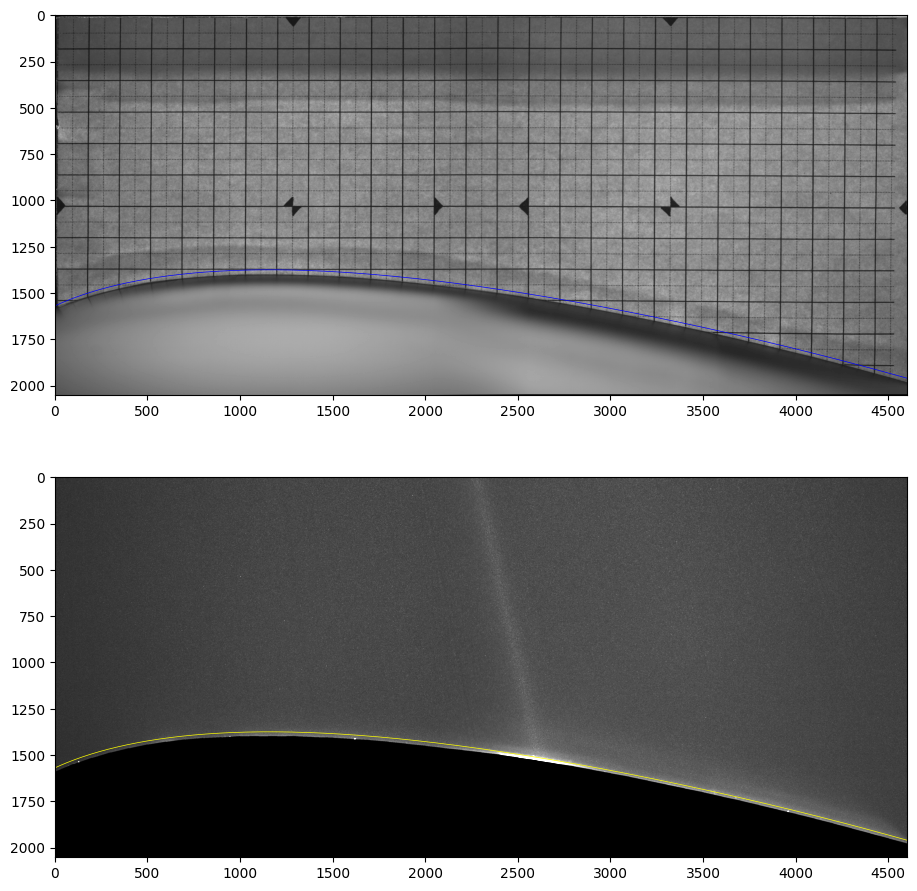

In [4]:
#@title Generate the airfoil coordinates
#@markdown The pixel density is 171 pixels/cm.
M = 171 #@param {type:"raw"}
#@markdown The airfoil chord length is 30 cm.
C = 30 #@param {type:"raw"}
#@markdown Number of points used to generate the coordinates.
n = 1001 #@param {type:"raw"}
#@markdown Shift the airfoil in x-direction.
x_offset = -380 #@param {type:"raw"}
#@markdown Shift the airfoil in y-direction.
y_offset = 36 #@param {type:"raw"}

# NACA 0025 airfoil parameters.
c = C * M
T = 0.25
a0 = 0.2969
a1 = -0.1260
a2 = -0.3516
a3 = 0.2843
a4 = -0.1015

xc = np.linspace(0, 1, n)
yc = (T / 0.2) * (a0 * xc ** 0.5 + a1 * xc + a2 * xc ** 2 + a3 * xc ** 3 + a4 * xc ** 4)

# Scale and shift the airfoil coordinates.
x = np.concatenate((xc, np.flip(xc)))
y = np.concatenate((yc, -np.flip(yc)))
x = x * c + x_offset
y = ht - (y * c + y_offset)

# Plot the curve.
fig, axs = plt.subplots(2, 1, figsize=(11, 11))
axs[0].imshow(cali, cmap='gray')
axs[0].plot(x, y, color='blue', linewidth=0.5)

axs[1].imshow(frame, cmap='gray', vmin=0, vmax=64)
axs[1].plot(x, y, color='yellow', linewidth=0.5)

# Modify tick labels and ticks.
tick_step = 250
for ax in axs:
    ax.set_xticks(range(0, wd, 2 * tick_step))
    ax.set_yticks(range(0, ht, tick_step))
    ax.set_xlim(0, wd)
    ax.set_ylim(ht, 0)

plt.show()

Initially, we employed `n = 1001` to generate a highly detailed airfoil surface. However, for efficiency purposes, we need to coarsen the coordinates to decrease the computational time required for generating the mask.

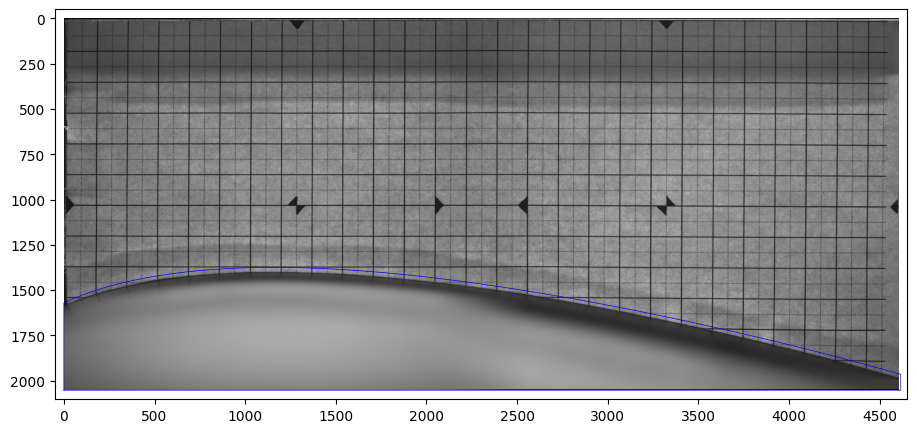

In [5]:
#@title Generate the coarse airfoil coordinates
#@markdown Number of points to skip.
N_P0 = 10 #@param {type:"raw"}

# Find indices of first and last elements.
il = np.argmax(x > 0)
ir = np.argmax(x >= wd)
xp = x[il-1:ir+N_P0:N_P0]
yp = y[il-1:ir+N_P0:N_P0]
xp = np.hstack((xp[0], xp, xp[-1], xp[0]))
yp = np.hstack((ht, yp, ht, ht))

# Plot the curve.
fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(cali, cmap='gray')
ax.plot(xp, yp, color='blue', linewidth=0.5)

# Modify tick labels and ticks.
tick_step = 250
ax.set_xticks(range(0, wd, 2 * tick_step))
ax.set_yticks(range(0, ht, tick_step))

# Adjust the axis limits.
dh = dw = 50
ax.set_xlim(-dw, wd+dw)
ax.set_ylim(ht+dh, -dh)
plt.show()

## <span style="color:blue;">Mask Generation</span>

Finally, in the last step, we construct a polygon using the airfoil coordinates and ascertain which points within the image fall within this polygon. This process yields the mask, preserving the same shape as the calibration image. The generated mask is now ready for application, effectively covering both the airfoil and a narrow region impacted by reflection.

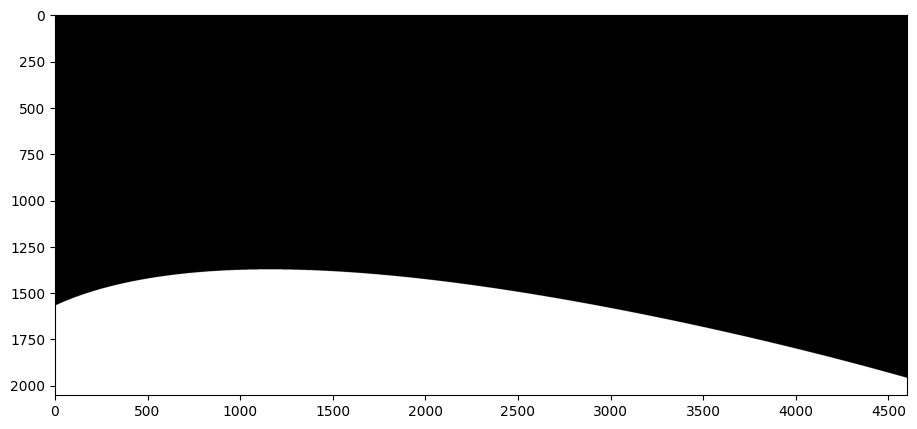

In [6]:
#@title Generate the mask
xm, ym = np.meshgrid(np.arange(wd), np.arange(ht))

# Reshape x and y to 1D arrays.
xm = xm.flatten()
ym = ym.flatten()

# Create a path object for the polygon.
polygon_path = mplpath.Path(np.column_stack((xp, yp)))

# Check if each point (x, y) is inside the polygon.
mask = polygon_path.contains_points(np.column_stack((xm, ym))).reshape((ht, wd))
fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(mask, cmap='gray')

# Modify tick labels and ticks.
tick_step = 250
ax.set_xticks(range(0, wd, 2 * tick_step))
ax.set_yticks(range(0, ht, tick_step))
plt.show()